# Data analysis:

In [211]:
# import statements
import matplotlib as plt
import pandas as pd
import numpy as np
import gender_guesser.detector as gender
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from scipy.stats import ttest_ind, ranksums
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

In [ ]:
# hard coded file names
output_csv = './city_of_seattle_with_sex.csv'

In [177]:
# read in the data (2017 salaries for all City of Seattle employees)
df = pd.read_csv('https://data.seattle.gov/api/views/2khk-5ukd/rows.csv')

In [178]:
# explore how big this dataset is
df.shape

(12346, 5)

12346 employees with 5 columns of data

In [179]:
# look at the data just to see what it looks like
df.head()

,Department,Last Name,First Name,Job Title,Hourly Rate
0,Arts and Culture,Boas-Du Pree,Sandra,Admin Staff Asst,34.48
1,Arts and Culture,Bolisay,Ronald,Publc Relations Spec,29.09
2,Arts and Culture,Chai,Grace,Cooperative Intern *,16.12
3,Arts and Culture,Childers,Calandra,"StratAdvsr3,Exempt",48.71
4,Arts and Culture,Crooks,Jennifer,Arts Prgm Spec,35.93


In [180]:
# remove spaces from the column names so that they will be 
# easier to play with later on
df.columns = ['depart', 'l_name', 'f_name', 'title', 'h_rate']

In [181]:
# double check that the removal worked
df.head()

,depart,l_name,f_name,title,h_rate
0,Arts and Culture,Boas-Du Pree,Sandra,Admin Staff Asst,34.48
1,Arts and Culture,Bolisay,Ronald,Publc Relations Spec,29.09
2,Arts and Culture,Chai,Grace,Cooperative Intern *,16.12
3,Arts and Culture,Childers,Calandra,"StratAdvsr3,Exempt",48.71
4,Arts and Culture,Crooks,Jennifer,Arts Prgm Spec,35.93


In [188]:
# add a column for sex and use 'gender_guesser' to estimate
# what sex each individual is
d = gender.Detector() # create sex detector object

df['sex'] = list(map(lambda x : d.get_gender(x), df['f_name']))
df.loc[df.sex == 'mostly_female', 'sex'] = 'female'
df.loc[df.sex == 'mostly_male', 'sex'] = 'male'


In [189]:
df.head()

,depart,l_name,f_name,title,h_rate,sex
0,Arts and Culture,Boas-Du Pree,Sandra,Admin Staff Asst,34.48,female
1,Arts and Culture,Bolisay,Ronald,Publc Relations Spec,29.09,male
2,Arts and Culture,Chai,Grace,Cooperative Intern *,16.12,female
3,Arts and Culture,Childers,Calandra,"StratAdvsr3,Exempt",48.71,unknown
4,Arts and Culture,Crooks,Jennifer,Arts Prgm Spec,35.93,female


In [94]:
# output the CSV file so that you can easily read it into R
df.to_csv(output_csv)

### Investigate the data a little more closely to figure out how jobs and salaries are distributed

In [56]:
# how many individuals exist for each sex group
df.groupby('sex').sex.count()

sex
andy        154
female     3859
male       7124
unknown    1209
Name: sex, dtype: int64

The City of Seattle clearly employs more males than females.

In [57]:
# print the proportion of total employees in each department
df.groupby('depart').depart.count()/sum(df.groupby('depart').depart.count())

depart
Arts and Culture                  0.002997
City Auditor                      0.000810
City Budget Office                0.003240
City Employees Retirement Syst    0.002430
City Light                        0.149846
Civil Service Commissions         0.000648
Community Police Commission       0.000324
Construction and Land Use         0.000486
Dept of Education & Early Lrng    0.004374
Dept of Finance & Admn Svc        0.049895
Dept of Neighborhoods             0.000081
Fire Department                   0.088531
Hearing Examiner                  0.000405
Human Services                    0.033452
Immigrant & Refugee Affairs       0.000729
Intergovernmental Relations       0.000972
Legislative                       0.000891
Legislative-City Council          0.008586
Mayor's Office                    0.003888
Neighborhoods Department          0.004536
Office for Civil Rights           0.002187
Office of Economic Development    0.002916
Office of Ethics & Elections      0.000810
Offi

A relatively small number of departments contain most of the employees (SPU, PD, Parks, and City Light).

In [190]:
# What if we break this down by sex within department

# How many employees are there for each department for each sex?
df.groupby(['depart', 'sex']).depart.count()

depart                          sex    
Arts and Culture                andy          1
                                female       26
                                male          7
                                unknown       3
City Auditor                    female        7
                                male          3
City Budget Office              female       22
                                male         16
                                unknown       2
City Employees Retirement Syst  andy          1
                                female       20
                                male          7
                                unknown       2
City Light                      andy         30
                                female      487
                                male       1153
                                unknown     180
Civil Service Commissions       female        5
                                male          3
Community Police Commission     female        2


On a quick glance, it looks like most large departments employ more males than females. We'll explore this further in R.

In [59]:
# proportions of each sex within each department
df.groupby(['depart', 'sex']).depart.count()/df.groupby(['depart']).depart.count()

depart                          sex    
Arts and Culture                andy       0.027027
                                female     0.702703
                                male       0.189189
                                unknown    0.081081
City Auditor                    female     0.700000
                                male       0.300000
City Budget Office              female     0.550000
                                male       0.400000
                                unknown    0.050000
City Employees Retirement Syst  andy       0.033333
                                female     0.666667
                                male       0.233333
                                unknown    0.066667
City Light                      andy       0.016216
                                female     0.263243
                                male       0.623243
                                unknown    0.097297
Civil Service Commissions       female     0.625000
                        

O.k., so it looks pretty clear that the City of Seattle employs more males than females, but do they get paid the same?

### Statistical tests on salary differences between males and females

(array([  4.,   0.,   0.,   0.,   0.,   0.,   0.,  35., 307.,  24.,  15.,
         58.,  51.,  62.,  60., 167., 236.,  81., 171., 180., 108., 112.,
        116., 140.,  96.,  79., 135., 106.,  84., 105., 107., 117., 137.,
        154., 100., 113.,  62.,  83.,  46.,  83.,  61.,  36.,  32.,  33.,
         30.,  33.,  20.,  13.,   7.,   9.,   3.,   8.,   2.,   5.,   5.,
          4.,   2.,   5.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   5.,
          0.,   0.,   1.,   0.,   2.,   0.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          1.]),
 array([  5.11  ,   6.3999,   7.6898,   8.9797,  10.2696,  11.5595,
         12.8494,  14.1393,  15.4292,  16.7191,  18.009 ,  19.2989,
         20.5888,  21.8787,  23.1686,  24.4585,  25.7484,  27.0383,
         28.3282,  29.6181,  30.908 ,  32.1979,  33.4878,  34.7777,
         36.0676,  37.3575,  38.6474,  39.9373

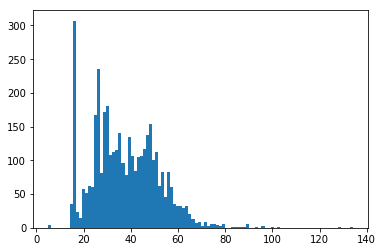

In [73]:
# histogram of female hourly rate
plt.pyplot.hist(df[df['sex']=='female']['h_rate'], bins=100)

(array([  7.,   0.,   0.,   0.,   0.,   0., 253., 111.,  46.,  80.,  85.,
        154., 253., 224., 196., 459., 194., 319., 300., 242., 272., 265.,
        266., 299., 494., 475., 287., 496., 222., 221., 119., 128., 154.,
         91.,  98.,  49.,  38.,  45.,  22.,  16.,  30.,  19.,  13.,   5.,
          3.,   9.,   3.,   7.,  12.,   9.,   9.,   1.,   1.,   3.,   2.,
          1.,   3.,   1.,   1.,   3.,   1.,   1.,   0.,   2.,   2.,   1.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  5.11 ,   6.728,   8.346,   9.964,  11.582,  13.2  ,  14.818,
         16.436,  18.054,  19.672,  21.29 ,  22.908,  24.526,  26.144,
         27.762,  29.38 ,  30.998,  32.616,  34.234,  35.852,  37.47 ,
         39.088,  40.706,  42.324,  43.942,  45.56 ,  47.178,  48.796,
         50.414,  52.032,  53.65 ,

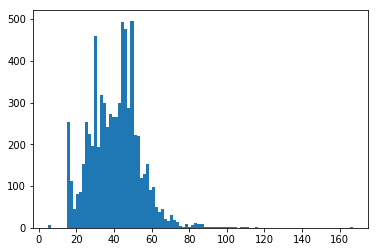

In [74]:
# histogram of male hourly rate
plt.pyplot.hist(df[df['sex']=='male']['h_rate'], bins=100)

Both of these histograms look fairly 'normal', so it should be o.k. to run a simple T-test for differences in mean compensation.

In [75]:
# median hourly rate by sex
df.groupby(['sex']).h_rate.median()

sex
andy       36.88
female     36.30
male       41.57
unknown    31.93
Name: h_rate, dtype: float64

In [76]:
# mean hourly rate by sex
df.groupby(['sex']).h_rate.mean()

sex
andy       37.993831
female     37.574457
male       40.578439
unknown    34.115054
Name: h_rate, dtype: float64

In [79]:
# the data look fairly normally distributed so I'm going to run a t-test on hourly rate between the sexes
ttest_ind(a=df[df['sex']=='male']['h_rate'], b=df[df['sex']=='female']['h_rate'])

Ttest_indResult(statistic=11.107692912188645, pvalue=1.6325584764614758e-28)

In [93]:
# just in case the data are not normal, I'll run a rank sum test
ranksums(x=df[df['sex']=='male']['h_rate'], y=df[df['sex']=='female']['h_rate'])

RanksumsResult(statistic=11.496587232409775, pvalue=1.3723496208774391e-30)

Clearly, the average hourly rate between males and females is different, with males making more. What could be driving this pattern? It may be that men have a greater proportion of the higher paying jobs. I'll investigate that a little below and Brad will look further in R.

In [257]:
# this is a function that will group salaries into bins for every $10
# so that I can look at proportions of males and females in each group
def roundCloses10(f_number): # float number
    remainder = f_number%10
    if remainder < 5:
        return (f_number-remainder)
    else:
        return (f_number + (10-remainder))

In [258]:
df['salary_bin'] = list(map(lambda x : roundCloses10(x), df['h_rate']))

In [259]:
# look at the sex proportions in each group
df.groupby(['salary_bin', 'sex']).depart.count()/df.groupby(['salary_bin']).depart.count()

salary_bin  sex    
10.0        female     0.363636
            male       0.636364
20.0        andy       0.015410
            female     0.386351
            male       0.417171
            unknown    0.181068
30.0        andy       0.013518
            female     0.334869
            male       0.536713
            unknown    0.114900
40.0        andy       0.011792
            female     0.274812
            male       0.637406
            unknown    0.075991
50.0        andy       0.007997
            female     0.278860
            male       0.650556
            unknown    0.062587
60.0        andy       0.020161
            female     0.331653
            male       0.573589
            unknown    0.074597
70.0        andy       0.013575
            female     0.276018
            male       0.656109
            unknown    0.054299
80.0        female     0.288136
            male       0.661017
            unknown    0.050847
90.0        female     0.243243
            male    

It seems like there is a pattern where females have a smaller proportion of high paying jobs than low playing jobs. We'll explore this more in R.

### Create a linear model

Using a simple T-test, women were shown to have lower salaries than men, but is this still true after accounting for each department? To look into this, I'm going to create a linear model and see.

In [14]:
print('Number of unique job titles:', len(set(df['title'])))
print('Number of total employees:', df.shape[0])

Number of unique job titles: 1026
Number of total employees: 12346


On average, each job is only observed 10 times. This makes me nervous that including this feature in a model will lead to overfitting, so I'm going to exclude it.

In [262]:
# create one hot encoded variables, and only keeps rows with a male or female classification
df_dummy = df.drop(['l_name', 'f_name', 'title', 'salary_bin'], axis=1)
df_dummy = df_dummy.loc[((df_dummy['sex']=='female') | (df_dummy['sex']=='male'))]

In [263]:
df_dummy.head()

,depart,h_rate,sex
0,Arts and Culture,34.48,female
1,Arts and Culture,29.09,male
2,Arts and Culture,16.12,female
4,Arts and Culture,35.93,female
5,Arts and Culture,39.29,female


In [264]:
df_dummy = pd.get_dummies(df_dummy, drop_first=True)

In [265]:
X_train, X_test, y_train, y_test = train_test_split(df_dummy.drop(columns=['h_rate'], axis=1),
                                                    df_dummy['h_rate'], 
                                                    test_size=0.00, random_state=42)
# I put 0% in the test set because I'm not interested in creating a model for future
# predictions. Instead, I'm just looking to see if sex is significantly correlated with compensation (e.g. P-value)

In [266]:
X_train.head()

,depart_City Auditor,depart_City Budget Office,depart_City Employees Retirement Syst,depart_City Light,depart_Civil Service Commissions,depart_Community Police Commission,depart_Construction and Land Use,depart_Dept of Education & Early Lrng,depart_Dept of Finance & Admn Svc,depart_Dept of Neighborhoods,...,depart_Planning and Community Develop,depart_Police Department,depart_Police Pension System,depart_Seattle Center,depart_Seattle Dept of Const and Insp,depart_Seattle Dept of HumanResources,depart_Seattle Dept of Transportation,depart_Seattle Information Technology,depart_Seattle Public Utilities,sex_male
116,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10090,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
10714,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3531,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [267]:
# Run a regression

X = X_train
y = y_train

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                 h_rate   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     122.3
Date:                Tue, 03 Apr 2018   Prob (F-statistic):               0.00
Time:                        13:21:04   Log-Likelihood:                -42398.
No. Observations:               10983   AIC:                         8.487e+04
Df Residuals:                   10946   BIC:                         8.514e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

Clearly sex is an important feature after accounting for the department (p-val < 0.001).